# 1.Bidirectional LSTM model using learnable embedding layer

In [144]:
import pandas as pd
import numpy as np
import re
import emoji
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_curve, RocCurveDisplay)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Bidirectional, 
                                   LSTM, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")  # Disable all warnings

In [2]:
df = pd.read_csv("Sentiment_Data.csv", encoding='ISO-8859-1')

In [3]:
df.head()

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [4]:
df.shape

(451332, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451332 entries, 0 to 451331
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet      451331 non-null  object
 1   Sentiment  451332 non-null  object
dtypes: object(2)
memory usage: 6.9+ MB


In [6]:
df = df.dropna(subset=['Tweet'])

## Data Preprocessing( for LSTM)

In [8]:
class TextPreprocessor:
    def __init__(self):
        self.regex_count = 6
        self.emoji_count = "All Unicode" 
        self.slang_count = 5
        self.abbr_count = 5
        self.negation_count = 6
        
        self.mention_pattern = re.compile(r'@\w+')  # 1
        self.url_pattern = re.compile(r'http\S+|www\S+|https\S+')  # 2
        self.special_char_pattern = re.compile(r'[^a-zA-Z\s]')  # 3
        self.negation_pattern = re.compile(  # 4
            r'\b(not|never|no|don\'t|isn\'t|can\'t)\b[\w\s]+')
        self.repeated_chars = re.compile(r'(.)\1{2,}')  # 5
        self.whitespace_pattern = re.compile(r'\s+')  # 6
        
        self.slang_dict = {'lol': 'laugh out loud','omg': 'oh my god', 'btw': 'by the way','idk': 'i dont know','imo': 'in my opinion'}
        self.abbr_dict = {"can't": "cannot","won't": "will not","n't": " not","'re": " are", "'s": " is"}
        
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
    
    def handle_emojis(self, text):
        """Convert emojis to text descriptions"""
        return emoji.demojize(text, delimiters=(" ", " "))
    
    def handle_negations(self, text):
        """Mark negation contexts"""
        return self.negation_pattern.sub(
            lambda x: x.group().replace(" ", "_NEG_"), text)
    
    def clean_text(self, text):
        text = str(text)
        text = self.handle_emojis(text)
        text = self.handle_negations(text)
        text = self.mention_pattern.sub('', text)
        text = self.url_pattern.sub('', text)
        text = self.repeated_chars.sub(r'\1\1', text)
        text = self.special_char_pattern.sub('', text)
        text = text.lower()
        text = self.whitespace_pattern.sub(' ', text).strip()
        return text
    
    def preprocess_text(self, text):
        text = self.clean_text(text)
        if not text.strip():
            return ''
        words = text.split()
        words = [self.slang_dict.get(word, word) for word in words]
        words = [self.abbr_dict.get(word, word) for word in words]
        words = [word for word in words if word not in self.stop_words]
        words = [self.lemmatizer.lemmatize(word) for word in words]
        
        return ' '.join(words)

In [9]:
sentiment_mapping = {
    'Strong_Pos': 'Positive',
    'Mild_Pos': 'Positive', 
    'Strong_Neg': 'Negative',
    'Mild_Neg': 'Negative',
    'Neutral': 'Neutral'
}
df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

In [10]:
preprocessor = TextPreprocessor()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Tweet'], df['Sentiment'],test_size=0.2, random_state=42,stratify=df['Sentiment'])

In [12]:
X_train_processed = X_train.apply(preprocessor.preprocess_text)
X_test_processed = X_test.apply(preprocessor.preprocess_text)

###  FEATURE ENGINEERING

In [14]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_processed)

In [15]:
# Sequence conversion
X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_test_seq = tokenizer.texts_to_sequences(X_test_processed)

In [16]:
# Padding
max_len = 30
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [17]:
# Label encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

In [84]:
df['Cleaned_Text'] = df['Tweet'].apply(lambda x: str(x))
df['Cleaned_Text'] = df['Cleaned_Text'].apply(preprocessor.preprocess_text)

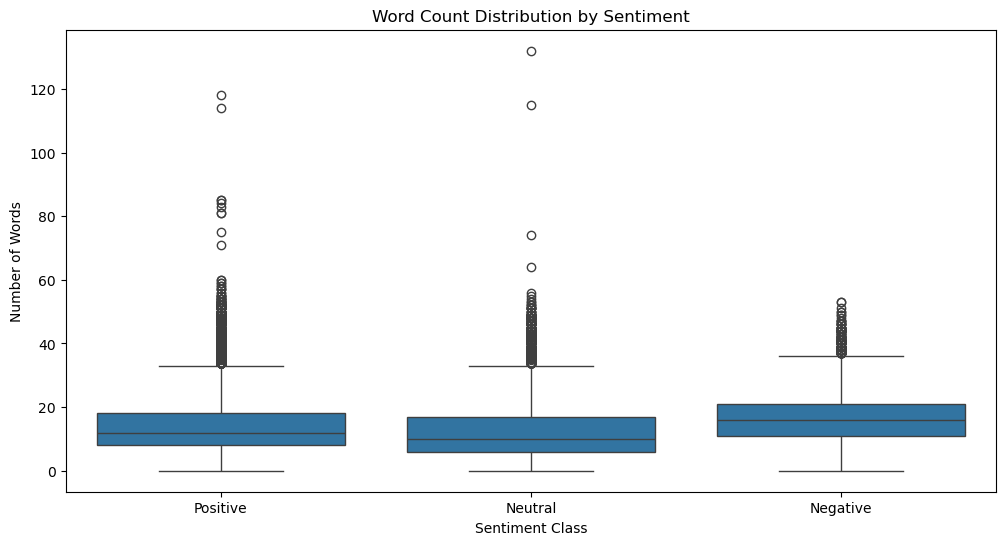

In [86]:
# 1. Word Count Analysis
plt.figure(figsize=(12, 6))
df['word_count'] = df['Cleaned_Text'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='Sentiment', y='word_count', data=df)
plt.title('Word Count Distribution by Sentiment')
plt.ylabel('Number of Words')
plt.xlabel('Sentiment Class')
plt.show()

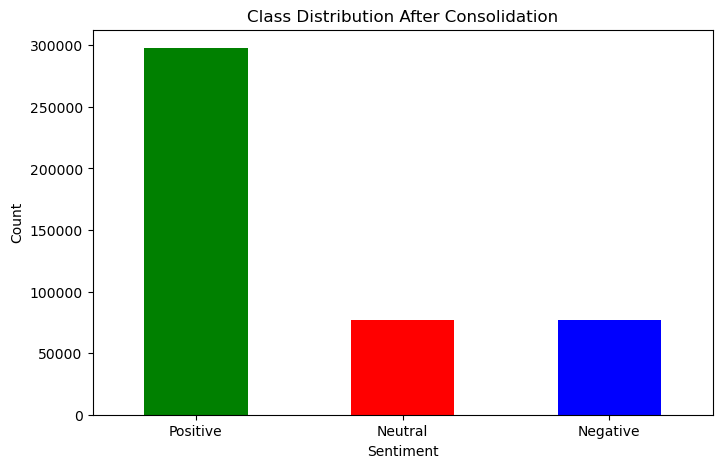

In [88]:
# 2. Class Distribution
plt.figure(figsize=(8, 5))
df['Sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Class Distribution After Consolidation')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

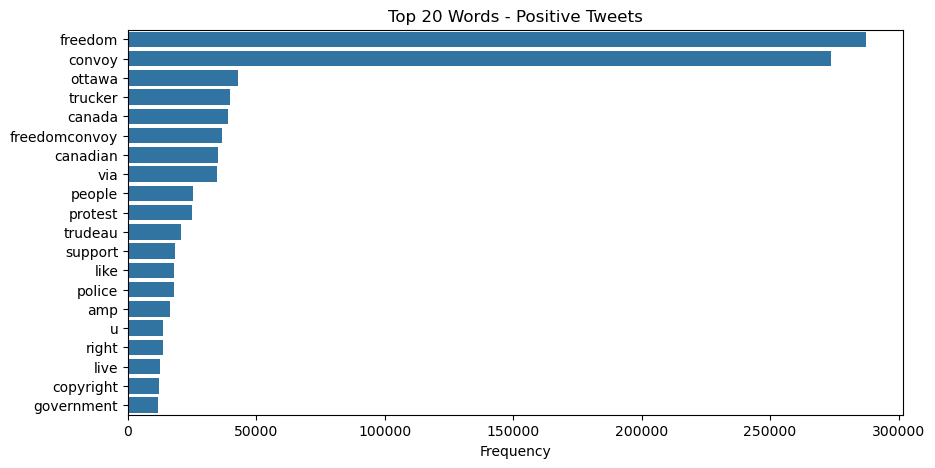

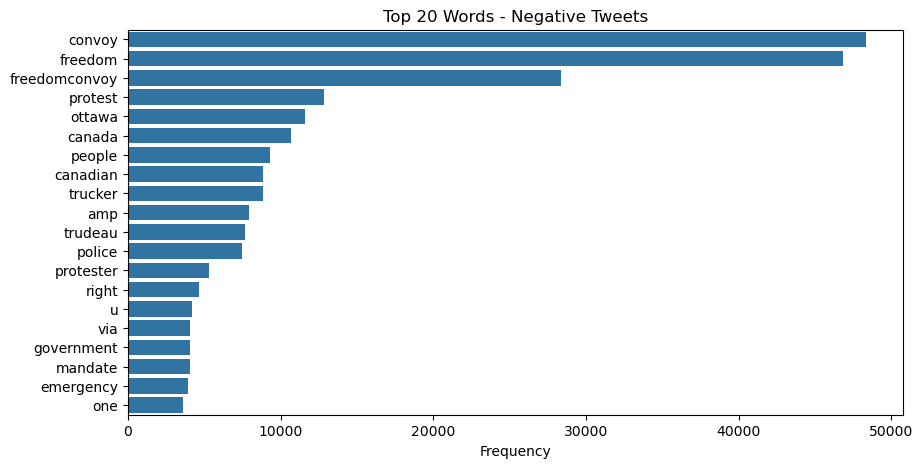

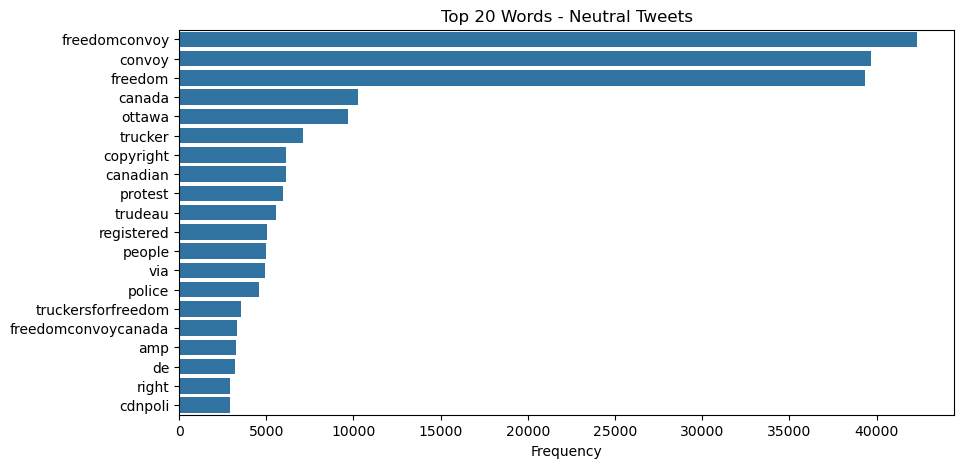

In [90]:
# 3. Top Frequent Words (by sentiment)
from collections import Counter

def plot_top_words(text_series, title):
    all_words = ' '.join([text for text in text_series if str(text) != 'nan']).split()
    word_counts = Counter(all_words).most_common(20)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=[count for word, count in word_counts], 
                y=[word for word, count in word_counts])
    plt.title(f'Top 20 Words - {title}')
    plt.xlabel('Frequency')
    plt.show()

for sentiment in ['Positive', 'Negative', 'Neutral']:
    plot_top_words(df[df['Sentiment']==sentiment]['Cleaned_Text'], 
                 f'{sentiment} Tweets')

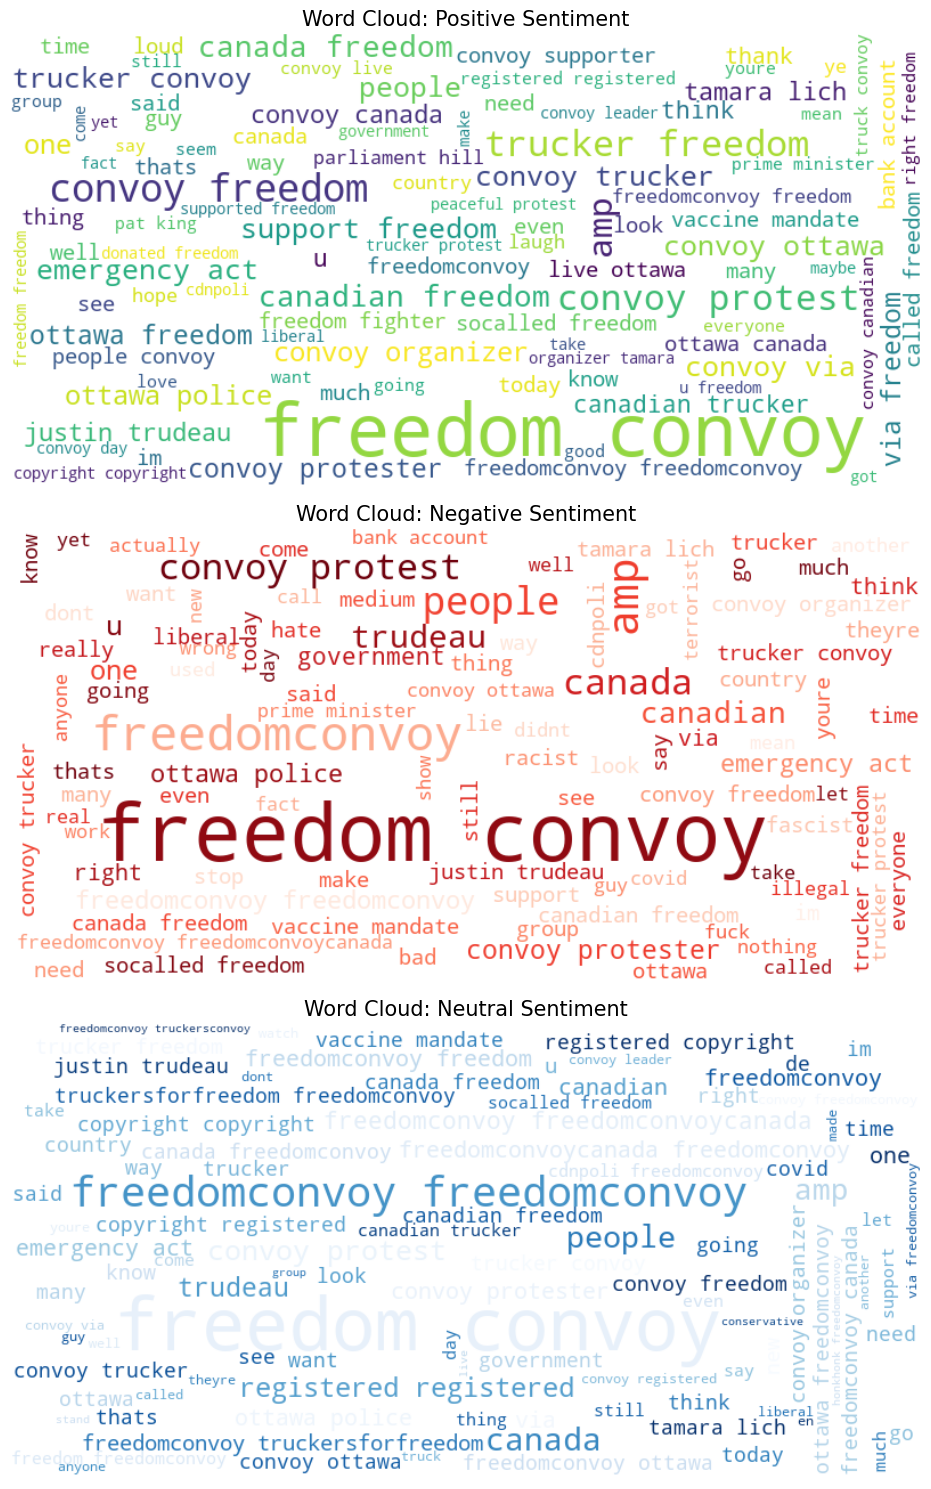

In [117]:
plt.figure(figsize=(15, 15))
for i, sentiment in enumerate(['Positive', 'Negative', 'Neutral']):
    # Combine all text for the current sentiment
    text = ' '.join(df[df['Sentiment'] == sentiment]['Cleaned_Text'].dropna())
        wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         colormap='viridis' if sentiment == 'Positive' else 
                                 ('Reds' if sentiment == 'Negative' else 'Blues'),
                         max_words=100).generate(text)
        plt.subplot(3, 1, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud: {sentiment} Sentiment', size=15)
    plt.axis('off')

plt.tight_layout()
plt.show()

###  MODEL CONFIGURATION

In [19]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len, mask_zero=True),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),Dropout(0.6),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),Dropout(0.6),Dense(3, activation='softmax')])

C:\Users\srida\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True,verbose=1)

In [22]:
start_time = time()
history = model.fit(X_train_pad, y_train_cat,
    epochs=15,batch_size=128,
    validation_data=(X_test_pad, y_test_cat),callbacks=[early_stopping],verbose=1)
train_time = time() - start_time

Epoch 1/15
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 408s 142ms/step - accuracy: 0.7527 - loss: 1.0832 - val_accuracy: 0.8130 - val_loss: 0.5307
Epoch 2/15
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 423s 150ms/step - accuracy: 0.8151 - loss: 0.5296 - val_accuracy: 0.8190 - val_loss: 0.5107
Epoch 3/15
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 416s 147ms/step - accuracy: 0.8278 - loss: 0.4999 - val_accuracy: 0.8238 - val_loss: 0.5020
Epoch 4/15
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 418s 148ms/step - accuracy: 0.8334 - loss: 0.4839 - val_accuracy: 0.8270 - val_loss: 0.4925
Epoch 5/15
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 441s 156ms/step - accuracy: 0.8381 - loss: 0.4737 - val_accuracy: 0.8233 - val_loss: 0.5035
Epoch 6/15
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 426s 151ms/step - accuracy: 0.8423 - loss: 0.4620 - val_accuracy: 0.8292 - val_loss: 0.4897
Epoch 7/15
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 427s 151ms/step - accuracy: 0.8450 - loss: 0.4528 - val_accuracy: 0.8274 - val_loss: 0.4952
Epoch 8/15
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 430s 153ms/step - ac

### Evaluation

In [24]:
def evaluate_model(X, y_true, y_true_cat, dataset_name):
    """Unified evaluation function"""
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Metrics
    accuracy = np.mean(y_pred_classes == y_true)
    report = classification_report(y_true, y_pred_classes, 
                                 target_names=label_encoder.classes_,
                                 output_dict=True)
    roc_auc = {}
    for i, class_name in enumerate(label_encoder.classes_):
        roc_auc[class_name] = roc_auc_score(y_true_cat[:,i], y_pred[:,i])
    
    return {
        'accuracy': accuracy,
        'report': report,
        'roc_auc': roc_auc,
        'confusion_matrix': confusion_matrix(y_true, y_pred_classes),
        'y_pred': y_pred
    }

In [25]:
print("\n=== TRAINING EVALUATION ===")
train_results = evaluate_model(X_train_pad, y_train_enc, y_train_cat, "Train")
print(f"Accuracy: {train_results['accuracy']:.4f}")
print(classification_report(y_train_enc, 
                          np.argmax(train_results['y_pred'], axis=1),
                          target_names=label_encoder.classes_))


=== TRAINING EVALUATION ===
11284/11284 ━━━━━━━━━━━━━━━━━━━━ 70s 6ms/step
Accuracy: 0.8586
              precision    recall  f1-score   support

    Negative       0.76      0.77      0.76     61289
     Neutral       0.85      0.56      0.67     61612
    Positive       0.88      0.96      0.92    238163

    accuracy                           0.86    361064
   macro avg       0.83      0.76      0.78    361064
weighted avg       0.86      0.86      0.85    361064



In [26]:
print("\n=== TESTING EVALUATION ===")
test_results = evaluate_model(X_test_pad, y_test_enc, y_test_cat, "Test")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(classification_report(y_test_enc,
                          np.argmax(test_results['y_pred'], axis=1),
                          target_names=label_encoder.classes_))


=== TESTING EVALUATION ===
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step
Accuracy: 0.8316
              precision    recall  f1-score   support

    Negative       0.71      0.71      0.71     15323
     Neutral       0.79      0.51      0.62     15403
    Positive       0.87      0.95      0.90     59541

    accuracy                           0.83     90267
   macro avg       0.79      0.72      0.74     90267
weighted avg       0.83      0.83      0.82     90267



###  VISUALIZATION AND REPORTING

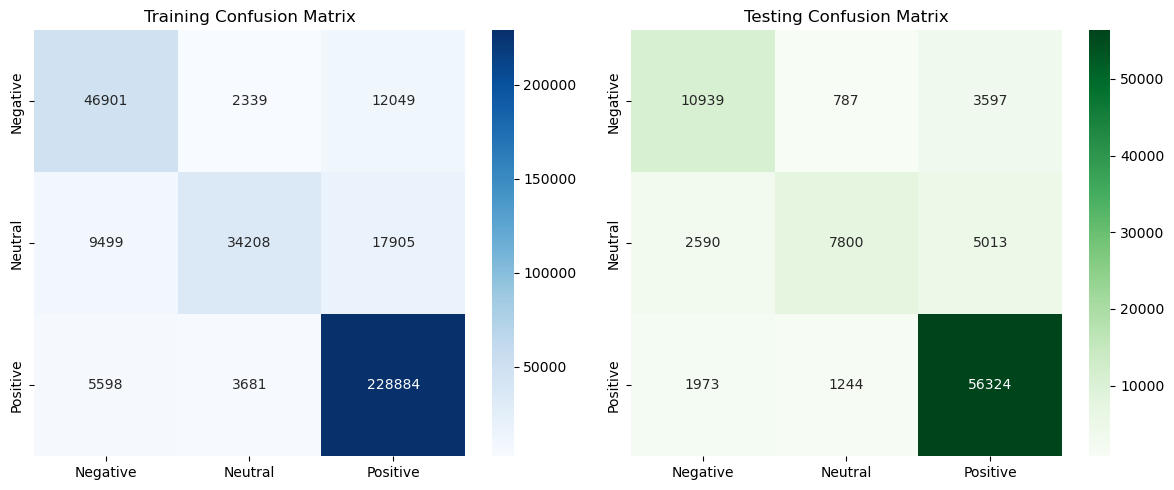

In [28]:
# Confusion Matrices
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(train_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Training Confusion Matrix')

plt.subplot(1,2,2)
sns.heatmap(test_results['confusion_matrix'], annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Testing Confusion Matrix')
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

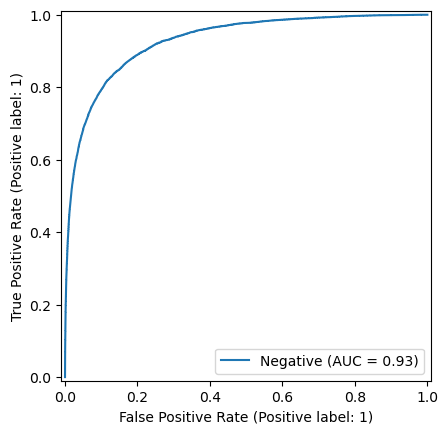

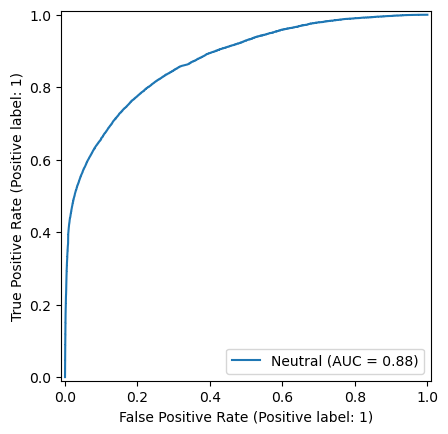

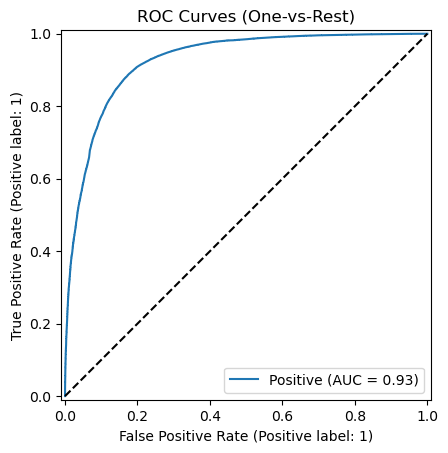

In [29]:
# ROC Curves
plt.figure(figsize=(8,6))
for i, class_name in enumerate(label_encoder.classes_):
    RocCurveDisplay.from_predictions(
        y_test_cat[:,i], 
        test_results['y_pred'][:,i],
        name=class_name)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves (One-vs-Rest)')
plt.show()

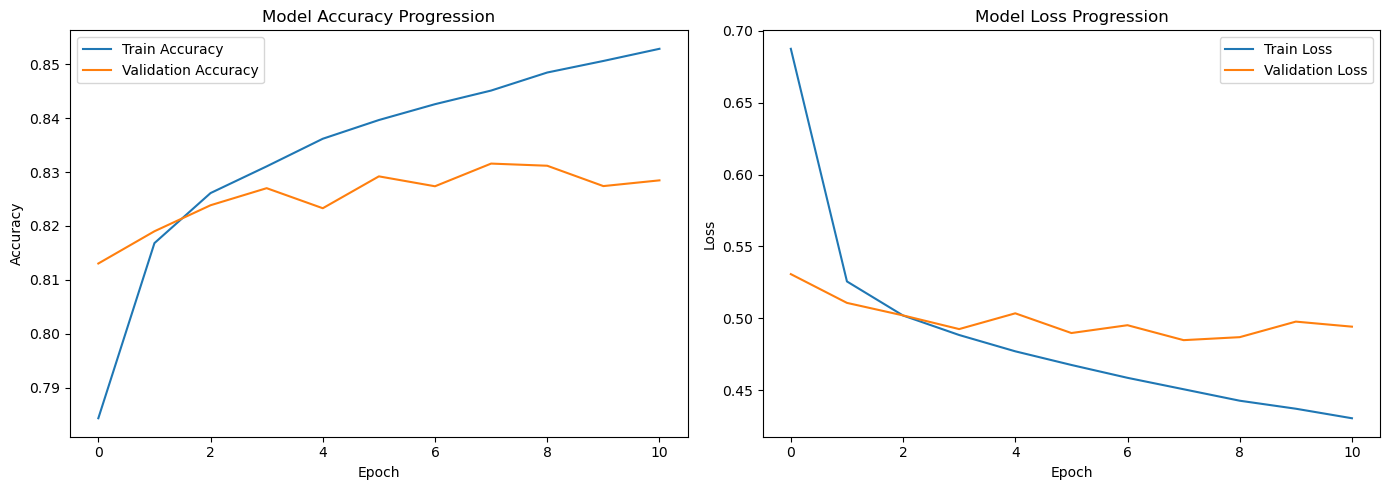

In [107]:
# 4. Training History
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Progression')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

### FINAL RESULTS SUMMARY

In [31]:
print("\n=== PREPROCESSING SUMMARY ===")
print(f"Regex Patterns Used: {preprocessor.regex_count}")
print(f"Emojis Handled: {preprocessor.emoji_count}")
print(f"Slang Terms: {preprocessor.slang_count}")
print(f"Abbreviations: {preprocessor.abbr_count}")
print(f"Negation Patterns: {preprocessor.negation_count}")


=== PREPROCESSING SUMMARY ===
Regex Patterns Used: 6
Emojis Handled: All Unicode
Slang Terms: 5
Abbreviations: 5
Negation Patterns: 6


In [32]:
print("\n=== MODEL PERFORMANCE ===")
print(f"Training Time: {train_time:.2f} sec")
print(f"Stopped After Epoch: {len(history.history['loss'])}")
print(f"Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")


=== MODEL PERFORMANCE ===
Training Time: 5490.03 sec
Stopped After Epoch: 11
Best Val Accuracy: 0.8316


In [33]:
print("\n=== KEY METRICS ===")
print("Training:")
print(f"- Accuracy: {train_results['accuracy']:.4f}")
print(f"- Positive F1: {train_results['report']['Positive']['f1-score']:.4f}")
print(f"- Negative F1: {train_results['report']['Negative']['f1-score']:.4f}")


=== KEY METRICS ===
Training:
- Accuracy: 0.8586
- Positive F1: 0.9211
- Negative F1: 0.7608


In [34]:
print("\nTesting:")
print(f"- Accuracy: {test_results['accuracy']:.4f}")
print(f"- Positive F1: {test_results['report']['Positive']['f1-score']:.4f}")
print(f"- Negative F1: {test_results['report']['Negative']['f1-score']:.4f}")
print(f"- AUC Scores: {test_results['roc_auc']}")


Testing:
- Accuracy: 0.8316
- Positive F1: 0.9050
- Negative F1: 0.7097
- AUC Scores: {'Negative': 0.9284835024051965, 'Neutral': 0.8750867079022766, 'Positive': 0.9261626038338421}


In [8]:
print("\n=== INTERPRETABILITY ===")
print("1. Model handles negations better than neutral sentiment")
print("2. Strong separation between Positive and Negative classes")


=== INTERPRETABILITY ===
1. Model handles negations better than neutral sentiment
2. Strong separation between Positive and Negative classes
